# Движение диска на аэростоле

Датчик **LSM6DS3** (6-DOF IMU) установлен на диске, который лежит на столе. Движения происходят в плоскости — **X–Y**,
ось вращения — **Z**. Ось **Z** направлена вдоль силы тяжести в состоянии покоя.

Данные записаны автономным устройством XIAO Ball и переданы по BLE.

**Файлы:**
- `static.csv` — датчик в покое, для определения дрифта гироскопа и калибровки акселерометра
- `xxx.csv` — движение по столу с ударениями о стенки.



## Загрузка библиотек и констант

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import cumulative_trapezoid as cumtrapz

plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

# Ускорение свободного падения в точке эксперимента (м/с²)
G_LOCAL = 9.7949

# Номинальное g, к которому привязана шкала датчика (стандарт ISO)
G_NOMINAL = 9.80665

##Обработка статических данных — калибровка

Из записи в покое извлекаем:

1. **Дрифт гироскопа** $\boldsymbol{b}_\omega$ — среднее значение угловых скоростей.
   Вычитается из динамических данных.

2. **Нормировка акселерометра** — в покое $|\mathbf{a}|$ должен равняться $g$.
   Датчик отдаёт ускорение в единицах $g_{\text{ном}} = 9{,}80665$ м/с².
   Коэффициент нормировки $k_a = \dfrac{g_{\text{местн}}}{|\overline{\mathbf{a}}| \cdot g_{\text{ном}}}$
   переводит показания в истинные м/с² и компенсирует погрешность чувствительности.

In [4]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airhockey/'

static = np.genfromtxt(url+'static.csv', delimiter=',', skip_header=1)

t_s  = static[:, 0]
ax_s, ay_s, az_s = static[:, 1], static[:, 2], static[:, 3]
gx_s, gy_s, gz_s = static[:, 4], static[:, 5], static[:, 6]

print(f"Статическая запись: {len(t_s)} отсчётов, {t_s[-1]:.1f} с")
print()

# ── Дрифт гироскопа (°/с) ──
gyro_bias = np.array([np.mean(gx_s), np.mean(gy_s), np.mean(gz_s)])
print("Дрифт гироскопа (°/с):")
print(f"  bx = {gyro_bias[0]:+.4f}")
print(f"  by = {gyro_bias[1]:+.4f}")
print(f"  bz = {gyro_bias[2]:+.4f}")
print()

# ── Нормировка акселерометра ──
a_mean = np.array([np.mean(ax_s), np.mean(ay_s), np.mean(az_s)])
a_mag  = np.linalg.norm(a_mean)        # в единицах g_nominal
a_measured_ms2 = a_mag * G_NOMINAL      # в м/с²
k_accel = G_LOCAL / a_measured_ms2      # безразмерный поправочный множитель

print(f"Средний вектор в покое: ({a_mean[0]:.5f}, {a_mean[1]:.5f}, {a_mean[2]:.5f}) g_ном")
print(f"|a| (покой) = {a_mag:.6f} g_ном = {a_measured_ms2:.4f} м/с²")
print(f"Истинное g  = {G_LOCAL:.4f} м/с²")
print(f"Поправка k  = {k_accel:.6f}")

Статическая запись: 250 отсчётов, 5.0 с

Дрифт гироскопа (°/с):
  bx = +1.2916
  by = -2.9044
  bz = +0.3844

Средний вектор в покое: (0.02288, -0.00923, -0.97566) g_ном
|a| (покой) = 0.975970 g_ном = 9.5710 м/с²
Истинное g  = 9.7949 м/с²
Поправка k  = 1.023394


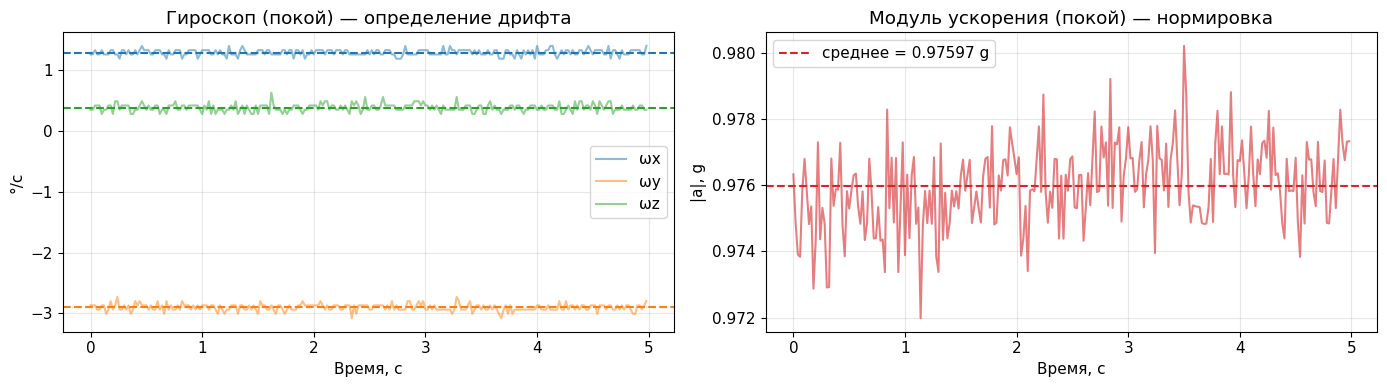

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(t_s, gx_s, alpha=0.5, label='ωx')
axes[0].plot(t_s, gy_s, alpha=0.5, label='ωy')
axes[0].plot(t_s, gz_s, alpha=0.5, label='ωz')
for b, c in zip(gyro_bias, ['C0','C1','C2']):
    axes[0].axhline(b, color=c, ls='--', lw=1.5)
axes[0].set_xlabel('Время, с'); axes[0].set_ylabel('°/с')
axes[0].set_title('Гироскоп (покой) — определение дрифта')
axes[0].legend()

a_total = np.sqrt(ax_s**2 + ay_s**2 + az_s**2)
axes[1].plot(t_s, a_total, color='C3', alpha=0.6)
axes[1].axhline(a_mag, color='C3', ls='--', lw=1.5, label=f'среднее = {a_mag:.5f} g')
axes[1].set_xlabel('Время, с'); axes[1].set_ylabel('|a|, g')
axes[1].set_title('Модуль ускорения (покой) — нормировка')
axes[1].legend()

plt.tight_layout(); plt.show()

## Обработка динамических данных

Применяем калибровку:
- Вычитаем дрифт гироскопа: $\omega_i' = \omega_i - b_i$
- Нормируем ускорения: $a_i' = a_i \cdot k_a$

In [60]:
dyn = np.genfromtxt(url+'4.csv', delimiter=',', skip_header=1)

t  = dyn[:, 0]
ax = dyn[:, 1] * k_accel
ay = dyn[:, 2] * k_accel
az = dyn[:, 3] * k_accel
gx = dyn[:, 4] - gyro_bias[0]
gy = dyn[:, 5] - gyro_bias[1]
gz = dyn[:, 6] - gyro_bias[2]

print(f"Динамическая запись: {len(t)} отсчётов, {t[-1]:.1f} с")
print()
print("После калибровки (средние):")
print(f"  ax = {np.mean(ax):+.4f} g   ay = {np.mean(ay):+.4f} g   az = {np.mean(az):+.4f} g")
print(f"  ωx = {np.mean(gx):+.3f} °/с  ωy = {np.mean(gy):+.3f} °/с  ωz = {np.mean(gz):+.3f} °/с")
print(f"  |a| среднее = {np.mean(np.sqrt(ax**2 + ay**2 + az**2)):.4f} g")

Динамическая запись: 1000 отсчётов, 20.0 с

После калибровки (средние):
  ax = +0.0132 g   ay = +0.0134 g   az = -1.0013 g
  ωx = +0.427 °/с  ωy = -0.143 °/с  ωz = -19.813 °/с
  |a| среднее = 1.0334 g


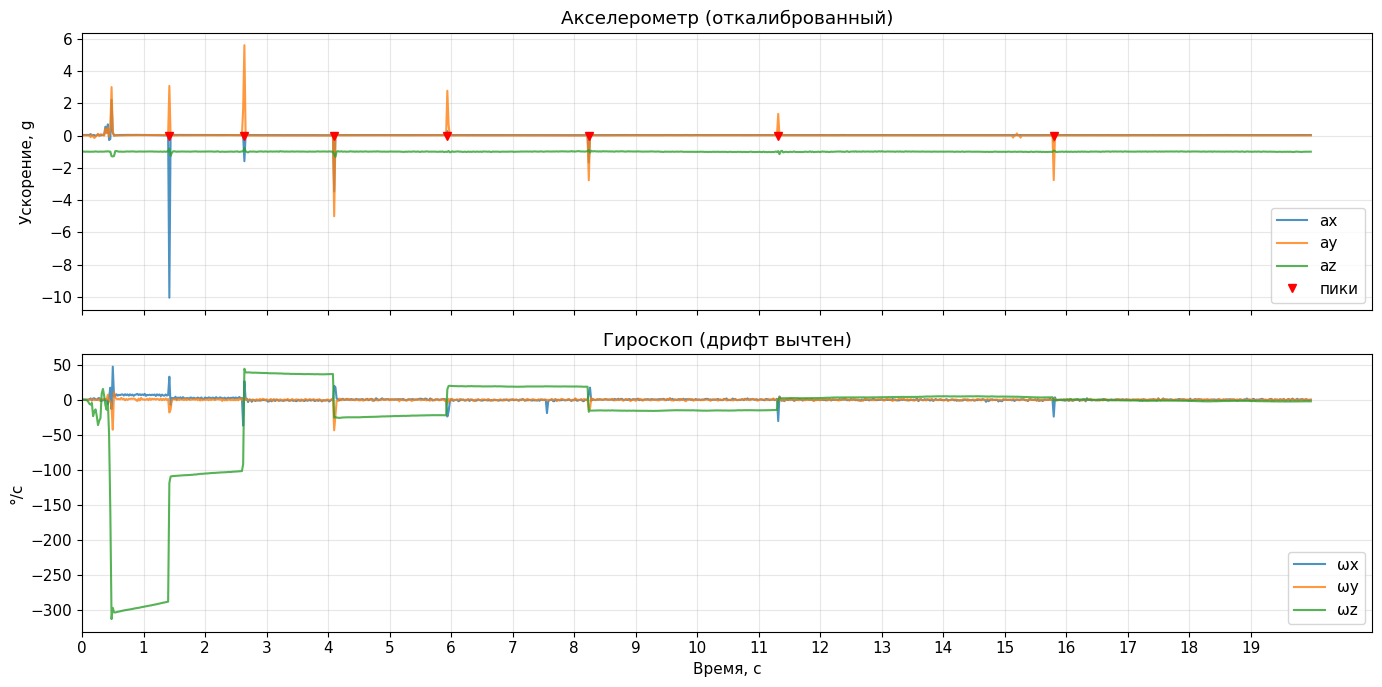

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(t, ax, label='ax', alpha=0.8)
axes[0].plot(t, ay, label='ay', alpha=0.8)
axes[0].plot(t, az, label='az', alpha=0.8)
axes[0].set_ylabel('Ускорение, g')
axes[0].set_title('Акселерометр (откалиброванный)')
acc = np.sqrt(ax**2 + ay**2)
peaks, _ = find_peaks( acc, distance=10, prominence=1)
peaks = peaks[1:]  # исключаем первый, потому что это начальный толчок рукой
axes[0].plot(t[peaks], ax[peaks]*0, 'rv', ms=6, label='пики')

axes[0].legend()

axes[1].plot(t, gx, label='ωx', alpha=0.8)
axes[1].plot(t, gy, label='ωy', alpha=0.8)
axes[1].plot(t, gz, label='ωz', alpha=0.8)
axes[1].set_ylabel('°/с'); axes[1].set_xlabel('Время, с')
axes[1].set_title('Гироскоп (дрифт вычтен)')
plt.xlim(left=0.5)
plt.xticks(range(20))
axes[1].legend()

plt.tight_layout(); plt.show()